Importamos librerias

In [87]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

Funcion de One Hot Encoder

In [88]:
# Archivo utilizado para crear la función de One Hot Encoding
############################################################# 

# Función auxiliar: Toma un df de variables categoricas y selección el top_x de categorias
def one_hot_top_x(cat_df, variable,top_x_labels):
    for label in top_x_labels:
        cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)

# Función One Hot Encoder: Toma un DF y le hace una transformación de One Hot Encoder para con las categorias más repetidas 
def one_hot_encoder(df,top_x):
    # Separo variables categoricas de númericas
    num_cols = df.select_dtypes(include=['float64', 'int']).columns.to_list()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    
    # Armo un DF solo con variables categoricas
    cat_df = df.drop(num_cols,axis=1)
    # Armo un DF solo con variables categoricas
    num_df = df.drop(cat_cols,axis=1)
   
    # Itero entre las variables categoricas y me quedo con el top 10 variables
    for variable in cat_cols:
        top_10 = [x for x in cat_df[variable].value_counts().sort_values(ascending=False).head(top_x).index]
        one_hot_top_x(cat_df,variable,top_10)
    
    cat_df = cat_df.drop(cat_cols,axis=1)
    df = pd.concat([cat_df,num_df], axis =1)
    
    return df

Importamos datos

In [89]:
# Levantamos los datos procesados
datos_meli = pd.read_excel('data_ready_to_model_api_simple.xlsx')
datos_meli['type'] = 'meli'

Analisis de Importancia de Variables

In [90]:
# Uno los DF
frames = [datos_meli, datos_privados]
datos = pd.concat(frames)

# Los paso por One Hot Encoder
# datos = one_hot_encoder(datos,100)

#Transformo a categorico
num_cols = datos.select_dtypes(include=['float64', 'int','category']).columns.to_list()
cat_cols = datos.select_dtypes(include=['object']).columns.to_list()
        
        # Armo un DF solo con variables categoricas
cat_df = datos.drop(num_cols,axis=1)
num_df = datos.drop(cat_cols,axis=1)

for variable in cat_cols:
    cat_df[variable] = cat_df[variable].astype("category")

datos = pd.concat([cat_df,num_df], axis =1)

datos.info()

# Separo los datos de Meli
datos_meli = datos[(datos['type'] == 'meli')] 
datos_meli = datos_meli.drop('type',axis=1)


datos_meli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51540 entries, 0 to 2481
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   currency_id          51540 non-null  category
 1   condition            51540 non-null  category
 2   Marca                51540 non-null  category
 3   Motor                48607 non-null  category
 4   Tipo de combustible  51414 non-null  category
 5   Modelo               51540 non-null  category
 6   Transmisión          48914 non-null  category
 7   Versión              51539 non-null  category
 8   adressstate_name     51540 non-null  category
 9   adresscity_name      51540 non-null  category
 10  type                 51540 non-null  category
 11  id                   51540 non-null  int64   
 12  price                51540 non-null  int64   
 13  Puertas              51540 non-null  int64   
 14  Kilómetros           51540 non-null  int64   
 15  Año                 

[20:37:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




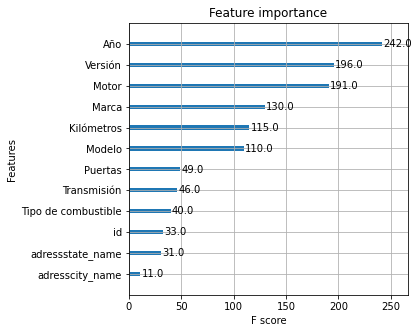

In [91]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical = True)

param = {
    'objective': 'reg:linear',
    'colsample_bytree' : 0.7999999999999999, 
    'learning_rate' : 0.1,
    'max_depth' : 6, 
    'alpha' : 10, 
    'n_estimators' : 1000, 
    'colsample_bylevel' :  0.6, 
    'subsample' : 0.8999999999999999 # the number of classes that exist in this datset
    }
num_round = 20  # the number of training iterations

#reg_cv = self.grid_search(xtr, ytr)
#xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
# Mirar la importancia de las variables
import matplotlib.pyplot as plt

xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


Volvemos a Levantar los datos para buscar los mejores hiperparametros

In [101]:
# Levantamos los datos procesados
datos_meli = pd.read_excel('data_ready_to_model_api_simple.xlsx')
datos_meli['type'] = 'meli'

In [103]:
# Uno los DF
frames = [datos_meli, datos_privados]
datos = pd.concat(frames)

# Los paso por One Hot Encoder
datos = one_hot_encoder(datos,100)

# Separo los datos de Meli
datos_meli = datos[(datos['type_meli'] == 1)] 
datos_meli = datos_meli.drop('type_privados',axis=1)
datos_meli = datos_meli.drop('type_meli',axis=1)

C:\Users\LUCIA~1.LOP\AppData\Local\Temp/ipykernel_16152/187505526.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)


Entrenamos el modelo & Aprendemos los Hiperametros

In [109]:
#separate the other attributes from the predicting attribute
x = datos_meli.drop('price',axis=1)

#separte the predicting attribute into Y for model training 
y = datos_meli['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Modelo Simple
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7999999999999999, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000, colsample_bylevel =  0.6, subsample = 0.8999999999999999 )
xg_reg.fit(X_train,y_train)

[20:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.7999999999999999,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [110]:
y_pred = xg_reg.predict(X_test)

print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000,2))


MAE: Mean Absolute Error: 404.38
MSE: Mean Squared Error: 5083208254.63
Root Mean Squared Error: 2254.6


Miramos resultados

Text(0.5, 1.0, 'Feature Importance')

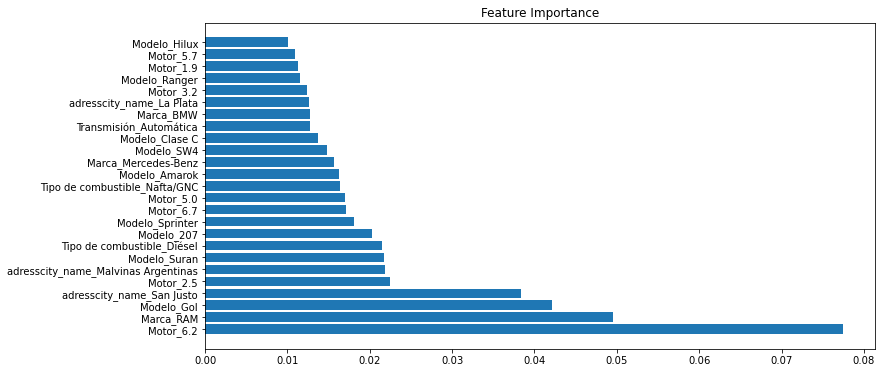

In [111]:
# Miro la importancia de las variables

feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(0,25), feature_importance[sorted_idx][::-1][:25], align='center')
plt.yticks(range(0,25), np.array(X_test.columns)[sorted_idx][::-1][:25])
plt.title('Feature Importance')

Optimizamos parametros

In [ ]:
########################################## Optimizando los hiperparametros
########################################## GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 300, 500],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBClassifier(seed = 20,tree_method="hist", enable_categorical=True)
# xgbr = xgb.train(seed = 20)
#clf_GS = GridSearchCV(estimator=xgbr, 
#                   param_grid=params,
#                   # scoring='neg_mean_squared_error',
#                   scoring = 'neg_mean_absolute_error',
#                   verbose=1)

grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 1,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred_test = grid_search.best_estimator_(X_test)
y_pred_train = grid_search.best_estimator_(X_train)

print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000000,2))


# Para ver overfitting
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))/1000000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))/1000000,2))

# Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
print("Lowest RMSE: ", round(((-clf_GridS.best_score_)**(1/2.0)/1000000),2))
# Lowest RMSE:  0.44
print("Lowest MSE: ", round((-clf_GridS.best_score_/1000000),2))


In [ ]:
best_estimator_.feature_importances_

Random Search

In [ ]:
########################################## RandomSearch

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=123)

params = { 'max_depth': [5, 10, 15, 20, 30, 40],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
           'n_estimators': [400, 500, 700, 800],
           'bootstrap' : [True, False]}

xgbr = xgb.XGBRegressor(seed = 20)
model_RandomS = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,
                         verbose=1)
model_RandomS.fit(X_train, y_train)

In [ ]:
mode_RandomS = cv_results_

In [80]:
print("Best parameters:", model_RandomS.best_params_)
print("Lowest RMSE: ", round(((-model_RandomS.best_score_)**(1/2.0)/1000),2))
print("Lowest MSE: ", round((-model_RandomS.best_score_/1000),2))


Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.6}
Lowest RMSE:  641.05
Lowest MSE:  410950122.08


In [81]:
print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000,2))


ValueError: Found input variables with inconsistent numbers of samples: [1137, 2238]